In [1]:
# data table
import pandas as pd
import os
#!pip install openpyxl

datadis=pd.read_excel(os.path.join('data','dataPeru_indicadores.xlsx'),
                     dtype={'Ubigeo': object})
datadis.head()

,Ubigeo,Departamento,Provincia,Distrito,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,010202,Amazonas,Bagua,ARAMANGO,10940,809.07,0.361182,37.545885,62.9,9.1
1,010201,Amazonas,Bagua,BAGUA,26091,150.99,0.584063,70.795501,25.4,0.7
2,010203,Amazonas,Bagua,COPALLIN,6319,99.05,0.467245,52.571361,45.4,2.1
3,010204,Amazonas,Bagua,EL PARCO,1492,18.48,0.489049,70.215409,59.9,1.5
4,010205,Amazonas,Bagua,IMAZA,24323,4430.84,0.298089,31.295719,88.4,11.7


In [2]:
# map

os.environ['USE_PYGEOS'] = '0'

import geopandas as gpd

datadismap=gpd.read_file(os.path.join('maps','DistritosMap.zip'))

datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,INSTITUCIO,geometry
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,IGN,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1..."
1,TACNA,TACNA,POCOLLAY,IGN,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9..."
2,TACNA,TACNA,CALANA,IGN,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9..."
3,TACNA,TACNA,TACNA,IGN,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9..."
4,TACNA,TACNA,SAMA,IGN,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9..."


In [3]:
#!pip install unidecode

In [4]:
capitalizeColumns=lambda x: x.str.upper().str.strip()
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].apply(capitalizeColumns)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].apply(capitalizeColumns)

In [5]:
import unidecode


byePunctuation=lambda x: unidecode.unidecode(x)
datadis[['Provincia','Distrito']]=datadis[['Provincia','Distrito']].applymap(byePunctuation)
datadismap[['PROVINCIA','DISTRITO']]=datadismap[['PROVINCIA','DISTRITO']].applymap(byePunctuation)

In [6]:
len(datadis.Distrito),len(datadismap.DISTRITO)

(1874, 1874)

In [7]:
datadis.Distrito.duplicated().sum(),datadismap.DISTRITO.duplicated().sum()

(154, 152)

In [8]:
# concatenating
datadis['provDist']=["+".join(pd) for pd in zip (datadis.Provincia,datadis.Distrito)]
datadismap['provDist']=["+".join(pd) for pd in zip (datadismap.PROVINCIA,datadismap.DISTRITO)]

In [9]:
# the new column looks like this:
datadis['provDist'].head()

0    BAGUA+ARAMANGO
1       BAGUA+BAGUA
2    BAGUA+COPALLIN
3    BAGUA+EL PARCO
4       BAGUA+IMAZA
Name: provDist, dtype: object

In [10]:
# replacing dashes and multiple spaces by a simple space
datadis.provDist=datadis.provDist.str.replace("\-|\_|\s+"," ",regex=True)
datadismap.provDist=datadismap.provDist.str.replace("\-|\_|\s+"," ",regex=True)

In [11]:
nomatch_df=set(datadis.provDist)- set(datadismap.provDist)
nomatch_gdf=set(datadismap.provDist)-set(datadis.provDist) 

In [12]:
len(nomatch_df), len(nomatch_gdf)

(8, 8)

In [13]:
# pick the closest match from nomatch_gdf for a value in nomatch_df
#!pip install thefuzz
from thefuzz import process
[(dis,process.extractOne(dis,nomatch_gdf)) for dis in sorted(nomatch_df)]

[('ANGARAES+HUAYLLAY GRANDE', ('ANGARAES+HUALLAY GRANDE', 98)),
 ('AYMARAES+CARAYBAMBA', ('AYMARAES+CARAIBAMBA', 95)),
 ('AYMARAES+HUAYLLO', ('AYMARAES+IHUAYLLO', 97)),
 ('HUARAZ+PAMPAS', ('HUARAZ+PAMPAS GRANDE', 90)),
 ('LEONCIO PRADO+DANIEL ALOMIAS ROBLES',
  ('LEONCIO PRADO+DANIEL ALOMIA ROBLES', 99)),
 ('LIMA+PUEBLO LIBRE', ('LIMA+MAGDALENA VIEJA', 49)),
 ('PIURA+26 DE OCTUBRE', ('PIURA+VEINTISEIS DE OCTUBRE', 86)),
 ('SAN MARTIN+PAPAPLAYA', ('SAN MARTIN+PAPA PLAYA', 98))]

In [14]:
# is this OK?
{dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

{'ANGARAES+HUAYLLAY GRANDE': 'ANGARAES+HUALLAY GRANDE',
 'AYMARAES+CARAYBAMBA': 'AYMARAES+CARAIBAMBA',
 'AYMARAES+HUAYLLO': 'AYMARAES+IHUAYLLO',
 'HUARAZ+PAMPAS': 'HUARAZ+PAMPAS GRANDE',
 'LEONCIO PRADO+DANIEL ALOMIAS ROBLES': 'LEONCIO PRADO+DANIEL ALOMIA ROBLES',
 'LIMA+PUEBLO LIBRE': 'LIMA+MAGDALENA VIEJA',
 'PIURA+26 DE OCTUBRE': 'PIURA+VEINTISEIS DE OCTUBRE',
 'SAN MARTIN+PAPAPLAYA': 'SAN MARTIN+PAPA PLAYA'}

In [15]:
# then:
changesDis_df={dis:process.extractOne(dis,nomatch_gdf)[0] for dis in sorted(nomatch_df)}

In [16]:
datadis.provDist.replace(changesDis_df,inplace=True)

In [17]:
datadismap=datadismap.merge(datadis, on='provDist')

In [18]:
# check
datadismap.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1874 entries, 0 to 1873
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   DEPARTAMEN                1874 non-null   object  
 1   PROVINCIA                 1874 non-null   object  
 2   DISTRITO                  1874 non-null   object  
 3   INSTITUCIO                1874 non-null   object  
 4   geometry                  1874 non-null   geometry
 5   provDist                  1874 non-null   object  
 6   Ubigeo                    1874 non-null   object  
 7   Departamento              1874 non-null   object  
 8   Provincia                 1874 non-null   object  
 9   Distrito                  1874 non-null   object  
 10  Poblacion                 1874 non-null   int64   
 11  Superficie                1874 non-null   float64 
 12  IDH2019                   1874 non-null   float64 
 13  Educ_sec_comp2019_pct     1874 non-null 

In [19]:
bye=['Departamento', 'Provincia', 'Distrito','INSTITUCIO']
datadismap.drop(columns=bye,inplace=True)

# keeping
datadismap.head()

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,provDist,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",TACNA+CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.578968,71.178389,15.8,0.8
1,TACNA,TACNA,POCOLLAY,"POLYGON ((-69.93475 -17.92557, -69.90467 -17.9...",TACNA+POCOLLAY,230108,22319,265.65,0.645954,75.825743,16.1,0.9
2,TACNA,TACNA,CALANA,"POLYGON ((-70.11604 -17.91106, -70.11457 -17.9...",TACNA+CALANA,230103,3338,108.38,0.564102,77.829717,15.9,3.3
3,TACNA,TACNA,TACNA,"POLYGON ((-70.31490 -17.94498, -70.30682 -17.9...",TACNA+TACNA,230101,80845,1877.78,0.696613,75.491958,7.4,0.6
4,TACNA,TACNA,SAMA,"POLYGON ((-70.42497 -17.88934, -70.48022 -17.9...",TACNA+SAMA,230109,2679,1115.98,0.552622,70.500250,52.4,10.8


In [20]:
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

In [21]:
# statistics
datadismap.IDH2019.describe()

count    1874.000000
mean        0.409405
std         0.140059
min         0.091195
25%         0.304729
50%         0.386020
75%         0.507002
max         0.845217
Name: IDH2019, dtype: float64

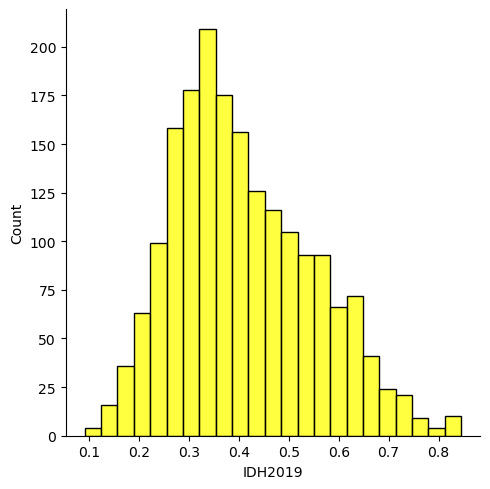

In [22]:
#!pip install seaborn
import seaborn as sea

sea.displot(datadismap.IDH2019, color='yellow')

<Axes: >

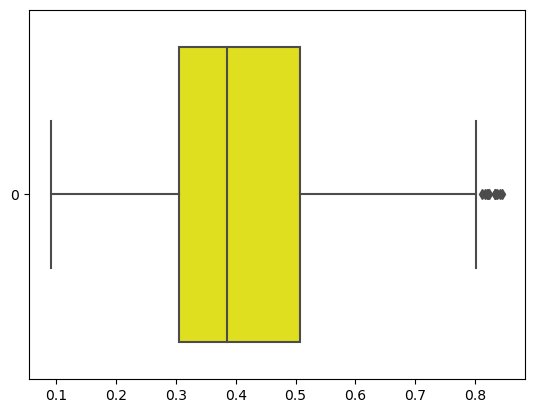

In [23]:
sea.boxplot(datadismap.IDH2019, color='yellow',orient='h')

In [ ]:
import mapclassify 
import numpy as np

np.random.seed(12345) # so we all get the same results!

# let's try 5 intervals
K=5
# same interval width, easy interpretation
ei5 = mapclassify.EqualInterval(datadismap['IDH2019'], k=K)
# same interval width based on standard deviation, easy - but not as the previous one, poor when high skewness
msd = mapclassify.StdMean(datadismap['IDH2019'])
# interval width varies, counts per interval are close, not easy to grasp, repeated values complicate cuts                                
q5=mapclassify.Quantiles(datadismap['IDH2019'],k=K)

# based on similarity, good for multimodal data 
mb5 = mapclassify.MaximumBreaks(datadismap['IDH2019'], k=K)
# based on similarity, good for skewed data
ht = mapclassify.HeadTailBreaks(datadismap['IDH2019']) # no K needed
# based on similarity, optimizer
fj5 = mapclassify.FisherJenks(datadismap['IDH2019'], k=K)
# based on similarity, optimizer
jc5 = mapclassify.JenksCaspall(datadismap['IDH2019'], k=K)
# based on similarity, optimizer
mp5 = mapclassify.MaxP(datadismap['IDH2019'], k=K)   

In [25]:
# a frequency table by default
ht

HeadTailBreaks

  Interval     Count
--------------------
[0.09, 0.41] |  1047
(0.41, 0.54] |   461
(0.54, 0.63] |   211
(0.63, 0.69] |    97
(0.69, 0.75] |    36
(0.75, 0.80] |    10
(0.80, 0.83] |     6
(0.83, 0.84] |     4
(0.84, 0.84] |     1
(0.84, 0.85] |     1

In [26]:
# group label
ht.yb

array([2, 3, 2, ..., 3, 3, 6])

In [27]:
# labels and counts
np.unique(ht.yb,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1047,  461,  211,   97,   36,   10,    6,    4,    1,    1],
       dtype=int64))

In [28]:
# ht.yb into a pandas Series

pd.Series(ht.yb).value_counts()

0    1047
1     461
2     211
3      97
4      36
5      10
6       6
7       4
9       1
8       1
dtype: int64

In [29]:
# these are the cuts, but it is not including the min value
ht.bins

array([0.40940512, 0.53944062, 0.62656757, 0.68924791, 0.74999441,
       0.79944501, 0.82690534, 0.8375162 , 0.84382218, 0.84521661])

In [30]:
# completing the bins
HT_bins=list(ht.bins)
HT_bins.insert(0,datadismap.IDH2019.min())

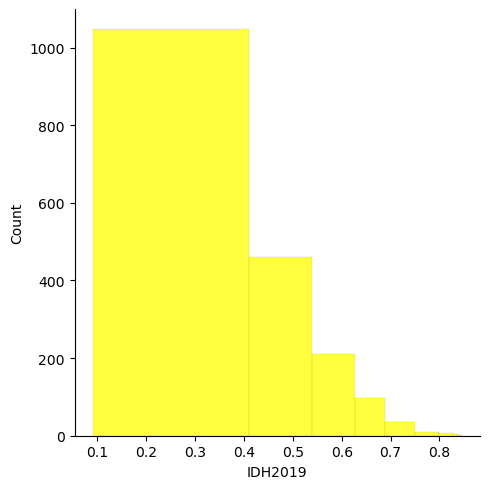

In [31]:
sea.displot(datadismap.IDH2019, bins=HT_bins,color='yellow')

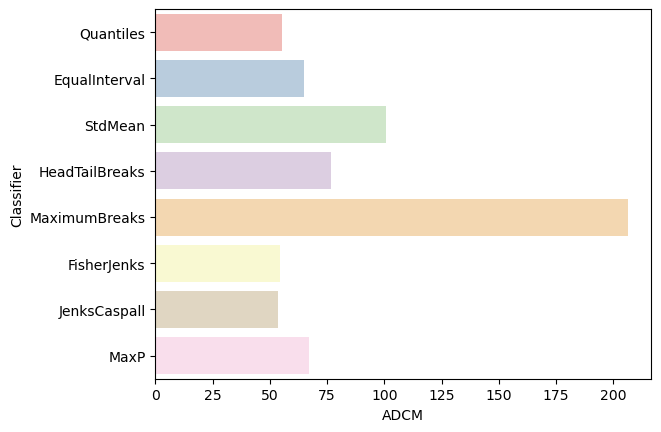

In [32]:
class5 = q5, ei5,msd, ht, mb5, fj5, jc5, mp5
# Collect ADCM for each classifier
fits = np.array([ c.adcm for c in class5])
# Convert ADCM scores to a DataFrame
adcms = pd.DataFrame(fits)
# Add classifier names
adcms['classifier'] = [c.name for c in class5]
# Add column names to the ADCM
adcms.columns = ['ADCM', 'Classifier']
ax = sea.barplot(
    y='Classifier', x='ADCM', data=adcms, palette='Pastel1'
)

In [33]:
datadismap['QU'] = q5.yb 
datadismap['FJ'] = fj5.yb
datadismap['JC'] = jc5.yb

In [34]:
# haow many cases per scheme:

class5new = q5,fj5, jc5
pd.DataFrame(
    {c.name: c.counts for c in class5new},
    index=['Class-{}'.format(i) for i in range(5)]
)

,Quantiles,FisherJenks,JenksCaspall
Class-0,375,351,352
Class-1,375,584,484
Class-2,374,424,403
Class-3,375,330,351
Class-4,375,185,284


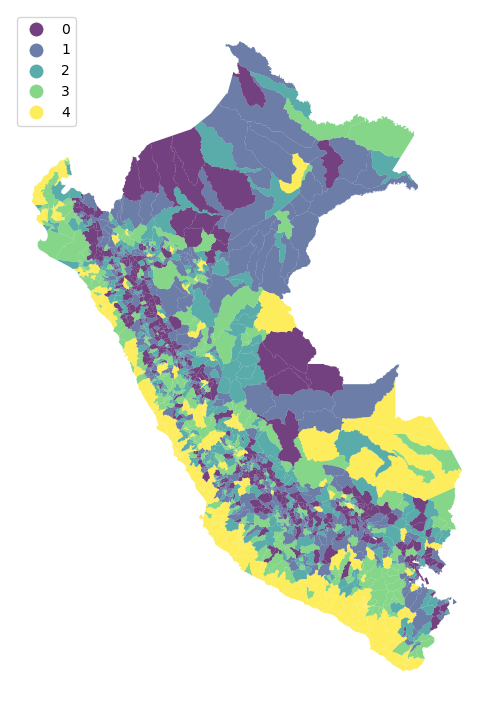

In [35]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='QU', 
        cmap='viridis', 
        categorical=True,
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()

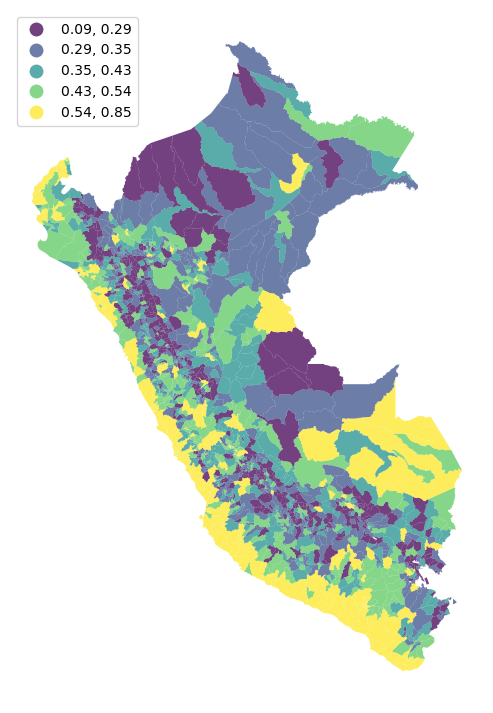

In [36]:
f, ax = plt.subplots(1, figsize=(9, 9))
datadismap.plot(column='IDH2019', 
        cmap='viridis',       
        scheme='Quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds=dict(loc=2),
        ax=ax
       )

ax.set_axis_off()


In [37]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

In [38]:
selected_variables = ['Educ_sec_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
datadismap[selected_variables].describe()


,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
count,1874.000000,1874.000000,1874.000000
mean,55.769523,38.593330,17.068783
std,15.728123,18.297153,16.354910
min,11.974433,1.100000,0.000000
25%,44.466678,24.900000,4.925000
50%,57.164771,35.300000,12.050000
75%,68.202230,49.275000,24.100000
max,91.744878,99.400000,96.500000


<Axes: >

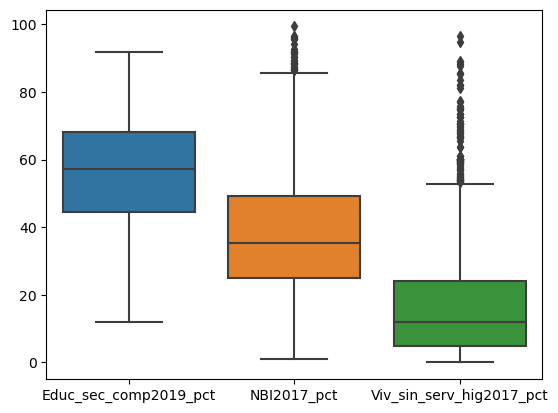

In [39]:
sea.boxplot(datadismap[selected_variables])

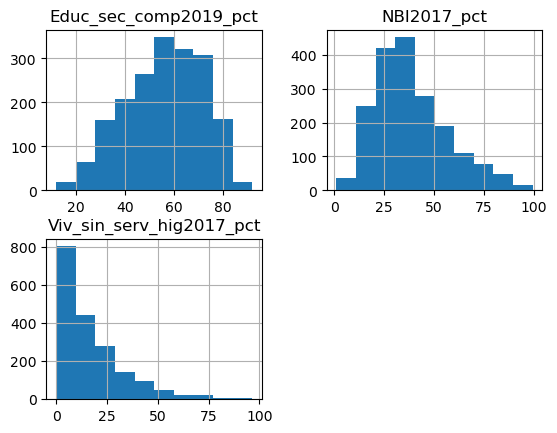

In [40]:
datadismap[selected_variables].hist();

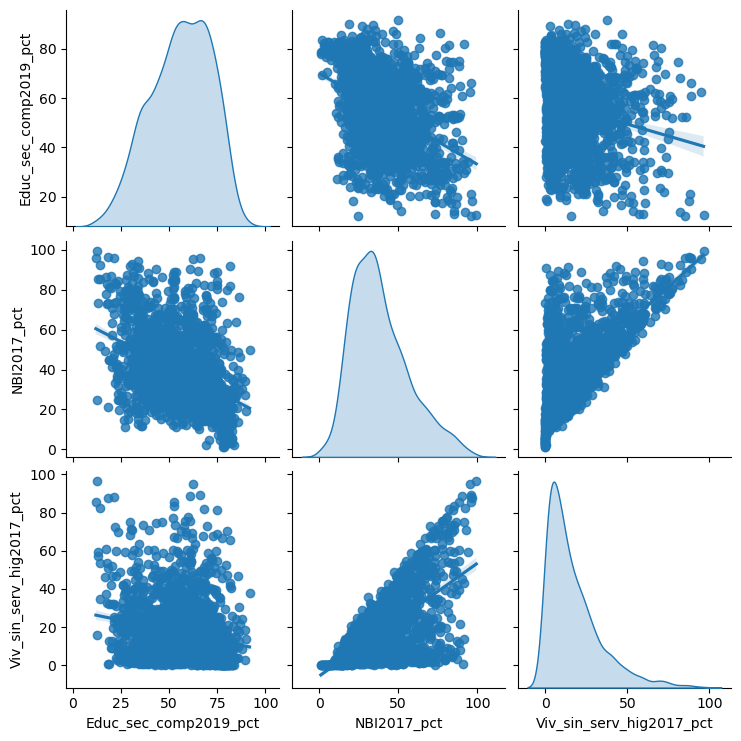

In [41]:
sea.pairplot(
    datadismap[selected_variables], kind="reg", diag_kind="kde"
)

<Axes: >

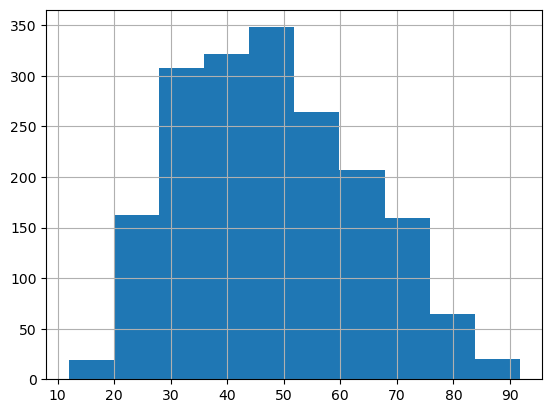

In [42]:
reverse=lambda x:abs(x-x.max())+x.min()

datadismap['Educ_sec_NO_comp2019_pct']=reverse(datadismap['Educ_sec_comp2019_pct'])
datadismap['Educ_sec_NO_comp2019_pct'].hist()

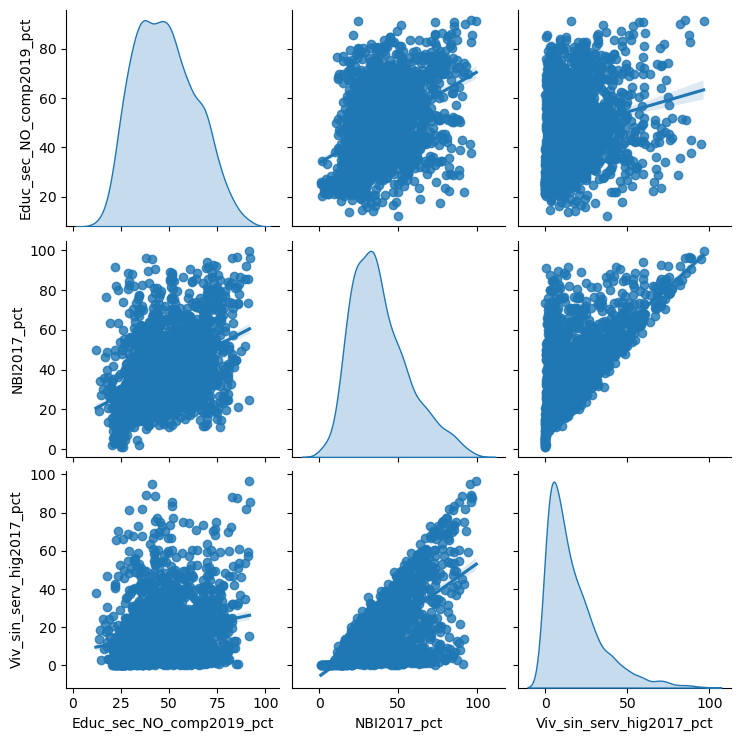

In [43]:
selected_variables_new = ['Educ_sec_NO_comp2019_pct',
                     'NBI2017_pct', 
                     'Viv_sin_serv_hig2017_pct']
sea.pairplot(
    datadismap[selected_variables_new], kind="reg", diag_kind="kde"
)


In [44]:
columnsToScale=selected_variables_new


from sklearn.preprocessing import robust_scale as rs
from sklearn.preprocessing import power_transform as pt
from sklearn.preprocessing import quantile_transform as qt

rs_result=rs(datadismap[columnsToScale])
pt_result=pt(datadismap[columnsToScale])
qt_result=qt(datadismap[columnsToScale])

<Axes: >

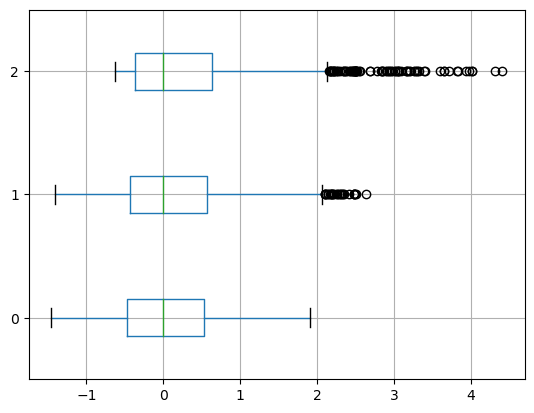

In [45]:
pd.DataFrame(rs_result).boxplot(vert=False)

<Axes: >

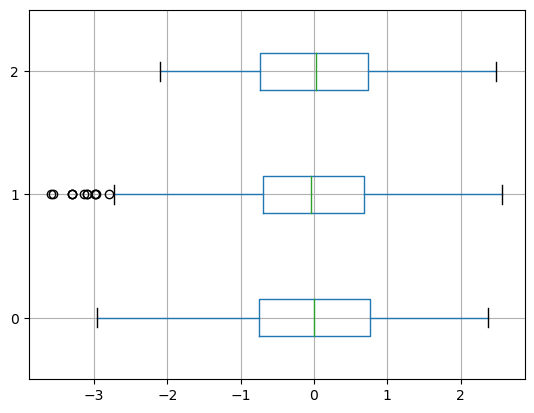

In [46]:
pd.DataFrame(pt_result).boxplot(vert=False)

<Axes: >

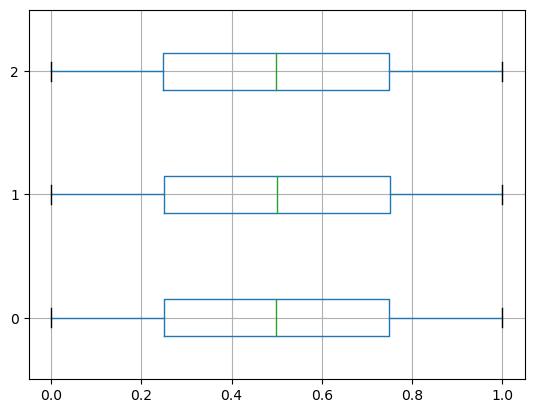

In [47]:
pd.DataFrame(qt_result).boxplot(vert=False)

In [48]:
# new names
selected_variables_new_t=[s+'_t' for s in selected_variables_new ]

# add colunms
datadismap[selected_variables_new_t]=qt_result

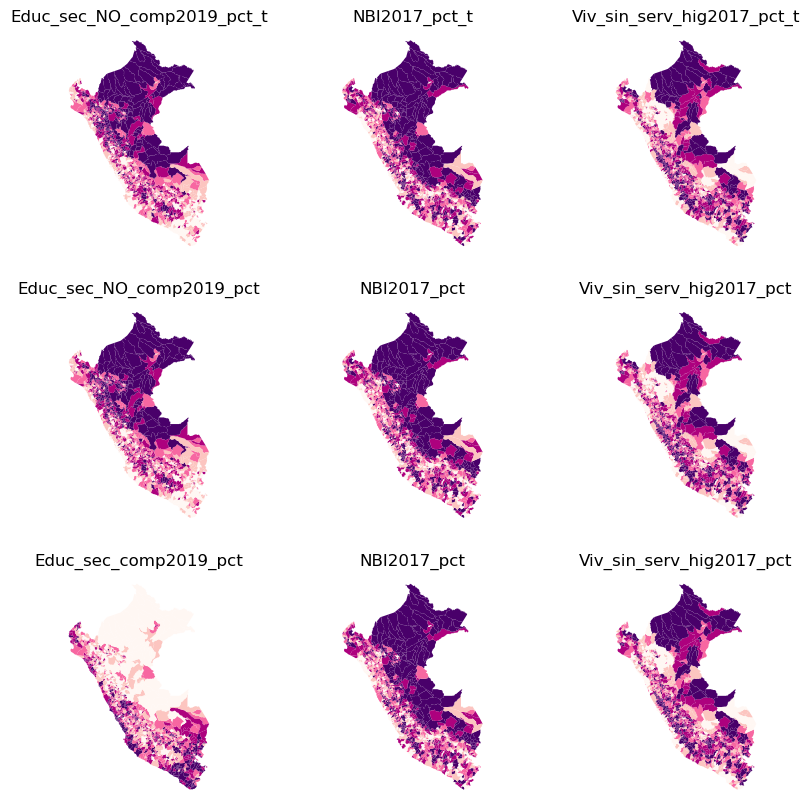

In [49]:
f, axs = plt.subplots( ncols=3, nrows=3,figsize=(10, 10))
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(selected_variables_new_t + selected_variables_new + selected_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    datadismap.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [50]:
# update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")

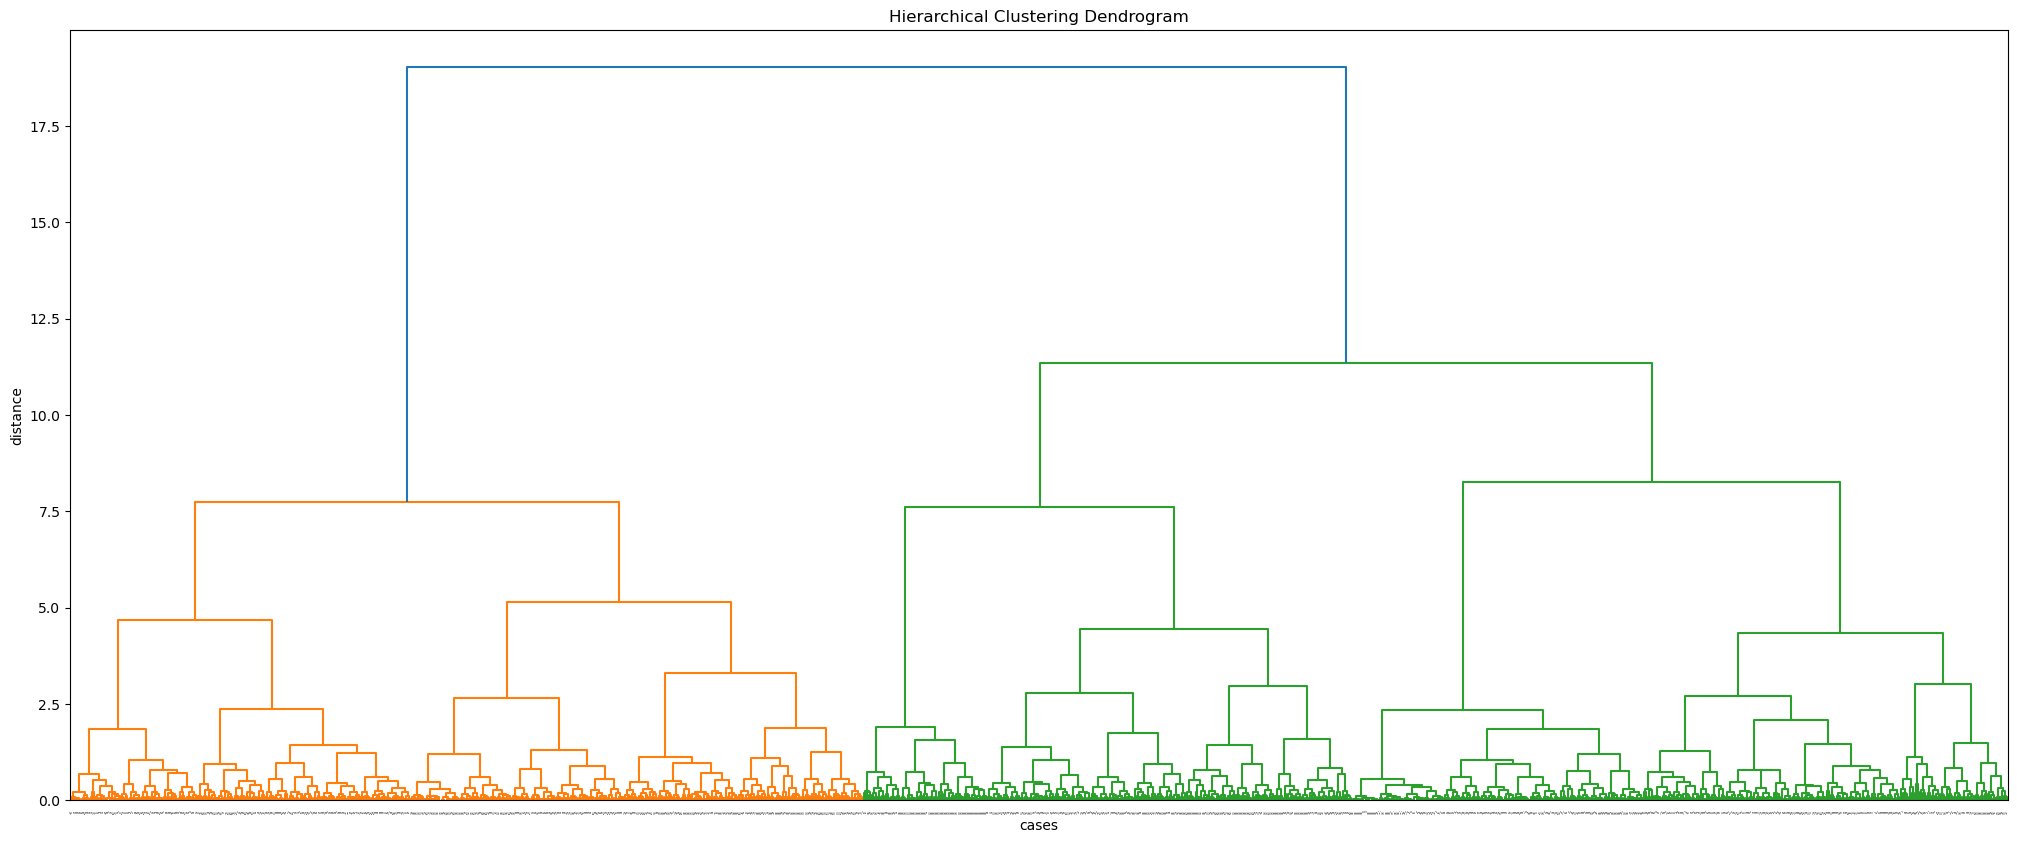

In [51]:
from scipy.cluster import hierarchy as hc


Z = hc.linkage(qt_result, 'ward')
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('cases')
plt.ylabel('distance')
hc.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=1,  # font size for the x axis labels
)
plt.show()

In [52]:
from sklearn.cluster import AgglomerativeClustering as agnes
# Set seed for reproducibility
np.random.seed(12345)
# Initialize the algorithm, requesting 3 clusters
model = agnes(linkage="ward", n_clusters=3).fit(datadismap[selected_variables_new_t])
# Assign labels to main data table
datadismap["hc_3"] = model.labels_

In [53]:
datadismap["hc_3"].value_counts()

1    767
0    635
2    472
Name: hc_3, dtype: int64

In [54]:
datadismap.groupby("hc_3")[selected_variables_new].mean()

,Educ_sec_NO_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct
hc_3,,,
0,32.829263,26.461732,8.322047
1,55.092692,51.354889,30.916688
2,56.684798,34.176907,6.333263


In [55]:
# Index db on cluster ID
datadismap_long = datadismap.set_index("hc_3").copy()
# Keep only variables used for clustering
datadismap_long = datadismap_long[selected_variables_new]
# Stack column names into a column, obtaining
# a "long" version of the dataset
datadismap_long = datadismap_long.stack()
# Take indices into proper columns
datadismap_long = datadismap_long.reset_index()
# Rename column names
datadismap_long = datadismap_long.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
datadismap_long.head()

,hc_3,Attribute,Values
0,0,Educ_sec_NO_comp2019_pct,32.540922
1,0,NBI2017_pct,15.800000
2,0,Viv_sin_serv_hig2017_pct,0.800000
3,0,Educ_sec_NO_comp2019_pct,27.893567
4,0,NBI2017_pct,16.100000


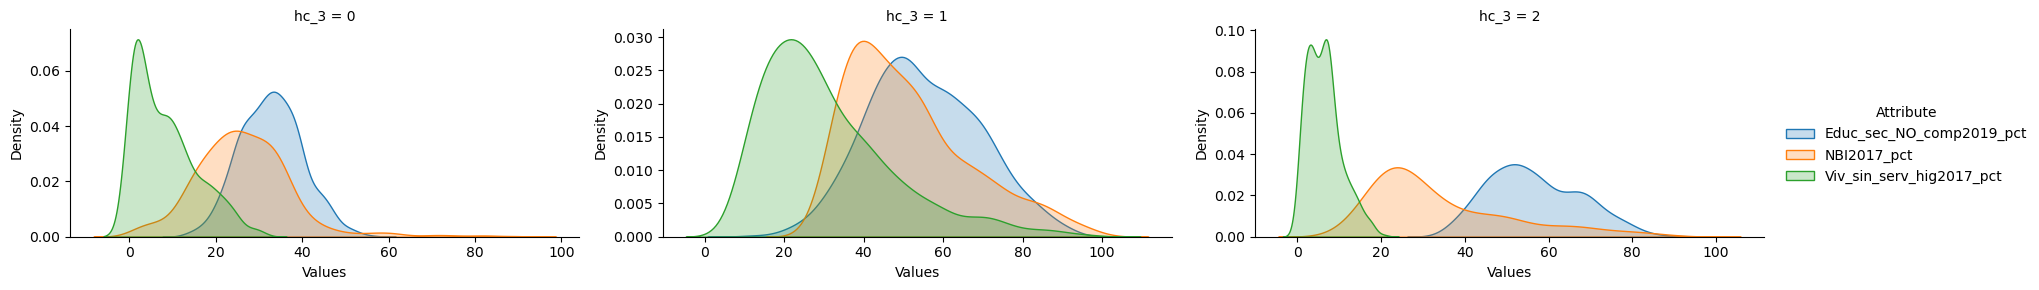

In [56]:
# Setup the facets
facets = sea.FacetGrid(
    data=datadismap_long,
    col="hc_3",
    hue="Attribute",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sns.kdeplot`
facets.map(sea.kdeplot, "Values", fill=True).add_legend()

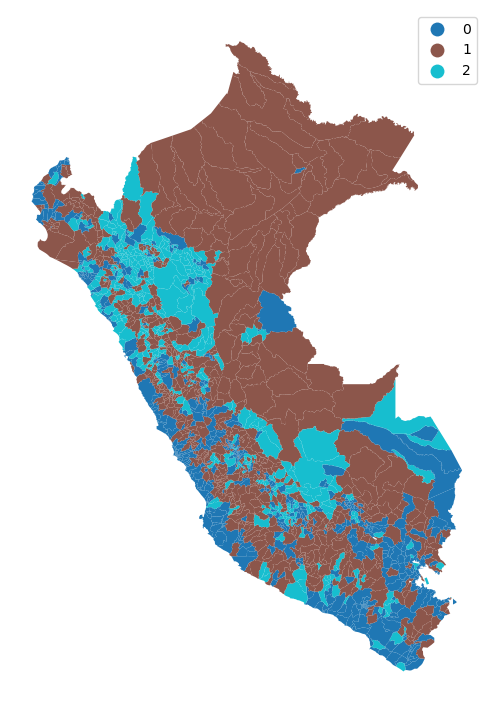

In [57]:
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
datadismap.plot(
    column="hc_3", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [90]:
#!pip install libpysal


from numba import jit
from libpysal.weights import Queen, Rook, KNN

# rook
w_rook = Rook.from_dataframe(datadismap) 

C:\Users\lizbe\anaconda3\envs\geopandas_env\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 89, 122.
  warnings.warn(message)


In [59]:
# rook
w_queen = Queen.from_dataframe(datadismap)

In [60]:
# k nearest neighbors
w_knn = KNN.from_dataframe(datadismap, k=4)

In [61]:
# first one
datadismap.head(1)

,DEPARTAMEN,PROVINCIA,DISTRITO,geometry,provDist,Ubigeo,Poblacion,Superficie,IDH2019,Educ_sec_comp2019_pct,NBI2017_pct,Viv_sin_serv_hig2017_pct,QU,FJ,JC,Educ_sec_NO_comp2019_pct,Educ_sec_NO_comp2019_pct_t,NBI2017_pct_t,Viv_sin_serv_hig2017_pct_t,hc_3
0,TACNA,TACNA,CORONEL GREGORIO ALBARRACIN LANCHIPA,"POLYGON ((-70.17413 -18.12896, -70.17461 -18.1...",TACNA+CORONEL GREGORIO ALBARRACIN LANCHIPA,230110,123662,187.74,0.578968,71.178389,15.8,0.8,4,3,4,32.540922,0.18121,0.061562,0.045546,0


In [62]:
# amount neighbors of that district
w_rook.neighbors[0] 

[3]

<Axes: >

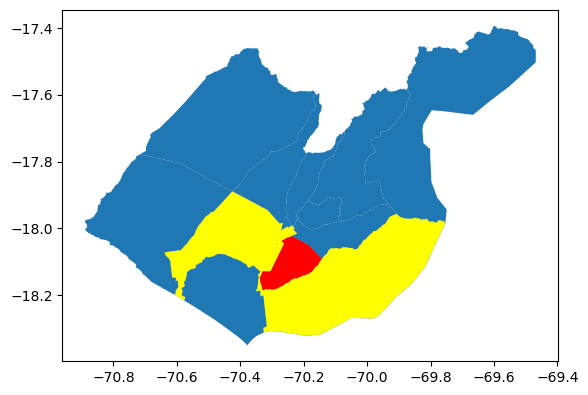

In [63]:
# see
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_rook.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

In [64]:
w_queen.neighbors[0]

[1, 3]

<Axes: >

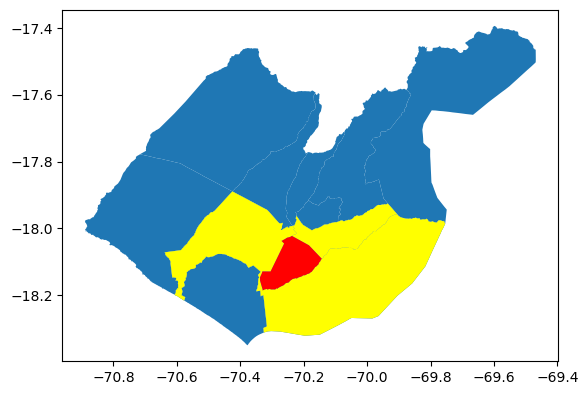

In [65]:
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_queen.neighbors[0] ,].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

In [66]:
w_knn.neighbors[0]

[3, 2, 1, 1806]

<Axes: >

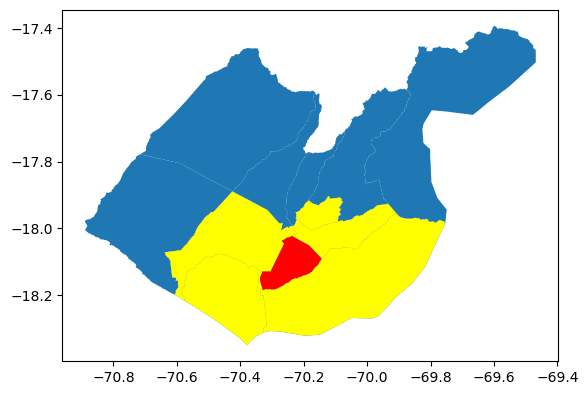

In [67]:
base=datadismap[datadismap.PROVINCIA=="TACNA"].plot()
datadismap.iloc[w_knn.neighbors[0],].plot(ax=base,facecolor="yellow")
datadismap.head(1).plot(ax=base,facecolor="red")

In [68]:
# all the neighbors by row
w_knn.neighbors

{0: [3, 2, 1, 1806],
 1: [2, 3, 5, 0],
 2: [1, 5, 3, 8],
 3: [0, 1, 2, 5],
 4: [6, 1806, 14, 13],
 5: [8, 2, 9, 1],
 6: [14, 7, 15, 4],
 7: [15, 6, 21, 14],
 8: [5, 2, 13, 9],
 9: [11, 5, 10, 2],
 10: [11, 17, 12, 9],
 11: [10, 12, 9, 17],
 12: [11, 24, 10, 19],
 13: [8, 17, 5, 18],
 14: [25, 6, 13, 4],
 15: [7, 21, 6, 36],
 16: [12, 11, 22, 9],
 17: [19, 10, 18, 20],
 18: [23, 20, 17, 19],
 19: [20, 17, 18, 23],
 20: [23, 18, 19, 29],
 21: [15, 7, 27, 36],
 22: [24, 12, 33, 16],
 23: [20, 18, 29, 31],
 24: [28, 12, 19, 22],
 25: [18, 23, 31, 14],
 26: [35, 36, 25, 31],
 27: [39, 30, 32, 21],
 28: [24, 19, 20, 34],
 29: [31, 23, 20, 34],
 30: [32, 41, 27, 39],
 31: [29, 23, 34, 20],
 32: [30, 41, 39, 27],
 33: [22, 38, 53, 24],
 34: [29, 31, 28, 23],
 35: [26, 37, 43, 45],
 36: [26, 21, 15, 35],
 37: [43, 45, 35, 74],
 38: [47, 33, 60, 53],
 39: [27, 30, 41, 32],
 40: [41, 73, 48, 32],
 41: [32, 30, 71, 39],
 42: [55, 57, 51, 39],
 43: [37, 45, 82, 74],
 44: [46, 50, 77, 83],
 45: [52,

In [69]:
# the matrix of neighboorhood:

pd.DataFrame(*w_knn.full()).astype(int) # 1 means both are neighbors

,0,1,2,3,4,5,6,7,8,9,...,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873
0,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1870,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1871,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# count of zeros
w_knn.nonzero

7496

In [71]:
# pct of neighboorhood (density)
w_knn.pct_nonzero

0.21344717182497333

In [72]:
# a district with NO neighbor?
w_knn.islands

[]

In [73]:
# needed for spatial correlation
w_knn.transform = 'R'

In [76]:
#!pip install esda

from esda.moran import Moran

moranIDH = Moran(datadismap['IDH2019'], w_knn)
moranIDH.I,moranIDH.p_sim

(0.6837588552721255, 0.001)

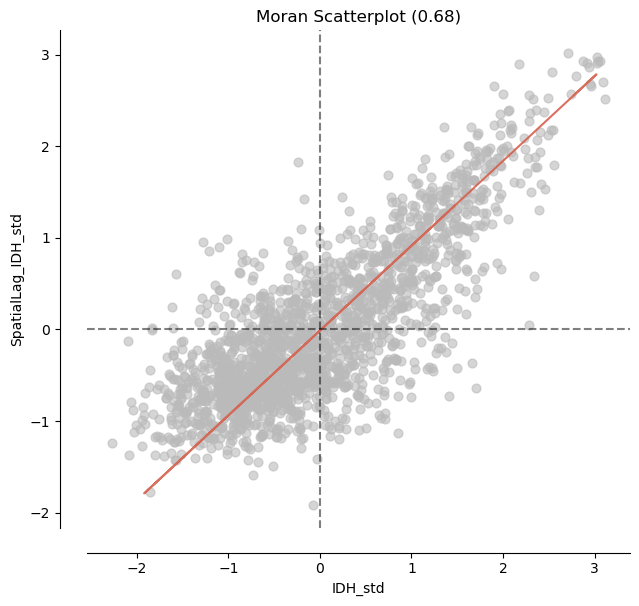

In [79]:
#!pip install splot
from splot.esda import moran_scatterplot

fig, ax = moran_scatterplot(moranIDH, aspect_equal=True)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

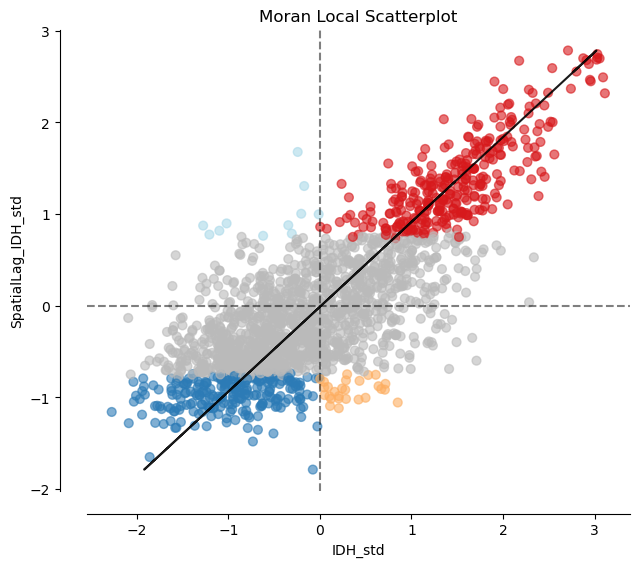

In [80]:
# The scatterplot with local info
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisaIDH = Moran_Local(y=datadismap['IDH2019'], w=w_knn,seed=2022)
fig, ax = moran_scatterplot(lisaIDH,p=0.05)
ax.set_xlabel('IDH_std')
ax.set_ylabel('SpatialLag_IDH_std')
plt.show()

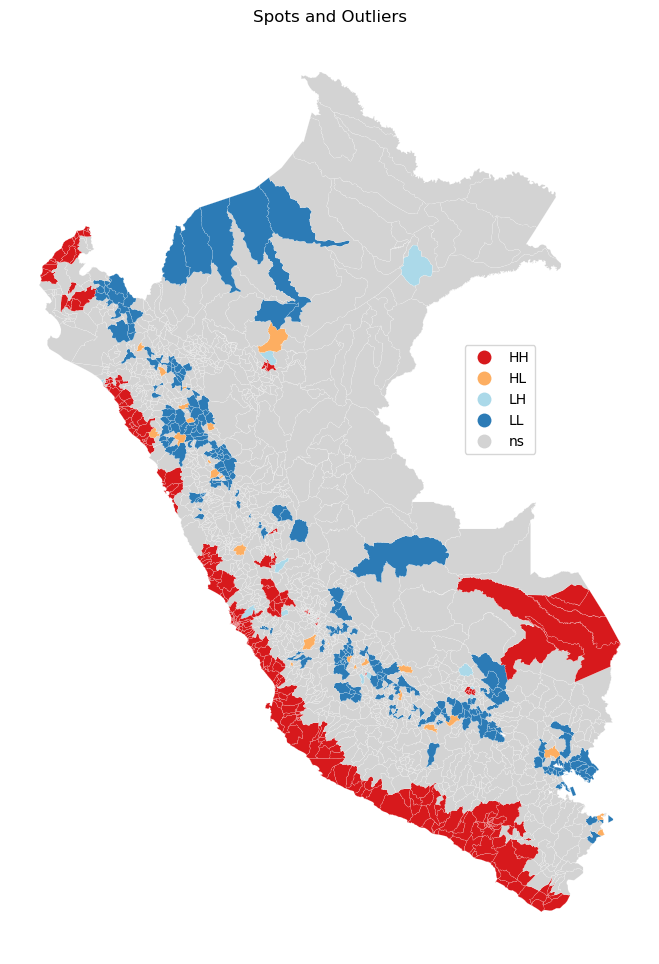

In [81]:
# the map with the spots and outliers

from splot.esda import lisa_cluster
f, ax = plt.subplots(1, figsize=(12, 12))
plt.title('Spots and Outliers')
fig = lisa_cluster(lisaIDH, 
                   datadismap,ax=ax,
                   legend_kwds={'loc': 'center left', 
                                'bbox_to_anchor': (0.7, 0.6)})
plt.show()

In [82]:
# quadrant
lisaIDH.q

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
# significance
lisaIDH.p_sim

array([0.005, 0.011, 0.005, ..., 0.002, 0.002, 0.001])

In [84]:
# quadrant: 1 HH,  2 LH,  3 LL,  4 HL
pd.Series(lisaIDH.q).value_counts()

3    873
1    618
4    209
2    174
dtype: int64

In [85]:
datadismap['IDH_quadrant']=[l if p <0.05 else 0 for l,p in zip(lisaIDH.q,lisaIDH.p_sim)  ]
datadismap['IDH_quadrant'].value_counts()

0    1283
1     308
3     245
4      27
2      11
Name: IDH_quadrant, dtype: int64

In [86]:
labels = [ '0 no_sig', '1 hotSpot', '2 coldOutlier', '3 coldSpot', '4 hotOutlier']

datadismap['IDH_quadrant_names']=[labels[i] for i in datadismap['IDH_quadrant']]

datadismap['IDH_quadrant_names'].value_counts()
                                  

0 no_sig         1283
1 hotSpot         308
3 coldSpot        245
4 hotOutlier       27
2 coldOutlier      11
Name: IDH_quadrant_names, dtype: int64

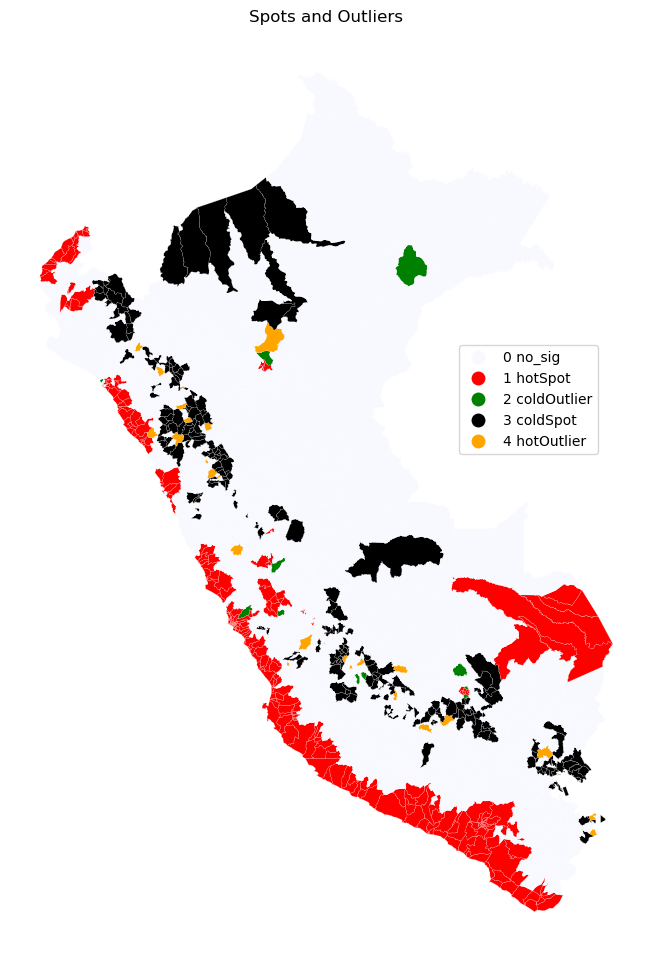

In [87]:
from matplotlib import colors
myColMap = colors.ListedColormap([ 'ghostwhite', 'red', 'green', 'black','orange'])



# Set up figure and ax
f, ax = plt.subplots(1, figsize=(12,12))
# Plot unique values choropleth including
# a legend and with no boundary lines

plt.title('Spots and Outliers')

datadismap.plot(column='IDH_quadrant_names', 
                categorical=True,
                cmap=myColMap,
                linewidth=0.1, 
                edgecolor='white',
                legend=True,
                legend_kwds={'loc': 'center left', 
                             'bbox_to_anchor': (0.7, 0.6)},
                ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [88]:
# final update
datadismap.to_file(os.path.join('maps',"dataMapPeru.gpkg"), layer='distritos', driver="GPKG")